# Análise de Tweets usando Processamento de Linguagem Natural (PLN)

## 1. Importação de Bibliotecas

- **pandas**: Manipulação e análise de dados.
- **matplotlib.pyplot e seaborn**: Visualização de dados.
- **TextBlob**: Biblioteca para processamento de linguagem natural, utilizada para análise de sentimentos.
- **train_test_split**: Divide o conjunto de dados em conjuntos de treino e teste.
- **CountVectorizer**: Converte uma coleção de documentos de texto em uma matriz de contagem de tokens.
- **MultinomialNB**: Implementação do classificador Naive Bayes para tarefas de classificação de texto.
- **accuracy_score, classification_report, confusion_matrix**: Métricas para avaliação do desempenho do modelo.
- **LatentDirichletAllocation**: Modelo para extração de tópicos em documentos.
- **WordCloud**: Criação de nuvens de palavras para visualização.
- **stopwords**: Palavras comuns que geralmente não contribuem para o significado de uma frase e são removidas durante o pré-processamento.
- **nltk**: Biblioteca de processamento de linguagem natural.
- **string**: Operações com strings.
- **tqdm**: Barra de progresso para iterações.

## 2. Download de Recursos Necessários

- Baixa as stopwords da NLTK, que serão usadas posteriormente para pré-processamento.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import string
from tqdm import tqdm
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ntsation/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Carregamento e Pré-processamento do Conjunto de Dados
Nesta parte do código, um conjunto de dados é carregado para análise. A descrição é a seguinte:

### 1. Leitura do Conjunto de Dados:

`df = pd.read_csv('tweets_analyze/covid19_tweets.csv')`: Lê um arquivo CSV contendo dados relacionados a tweets sobre a COVID-19. O conjunto de dados é armazenado em um DataFrame do pandas chamado `df`.
### 2. Barra de Progresso:

`tqdm.pandas()`: Configura o uso da barra de progresso `tqdm` para monitorar o progresso de operações que envolvem o DataFrame. Isso é útil para acompanhar o progresso de tarefas demoradas, como pré-processamento de grandes conjuntos de dados.

In [2]:
df = pd.read_csv('/home/ntsation/Documents/projetos-linux/tweets_analyze/covid19_tweets.csv')
tqdm.pandas()

## Análise de Sentimentos usando TextBlob
Nesta parte do código, uma análise de sentimentos é realizada nos textos dos tweets utilizando a biblioteca TextBlob. Aqui está uma descrição detalhada:

### 1. Função de Análise de Sentimentos:

- `def get_sentiment(text)`: Define uma função chamada `get_sentiment` que recebe um texto como entrada.
- `analysis = TextBlob(str(text))`: Cria uma instância da classe `TextBlob` para realizar a análise de sentimentos no texto fornecido.
- `return analysis.sentiment.polarity`: Retorna a polaridade do sentimento do texto. A polaridade varia de -1 (negativo) a 1 (positivo).
### 2. Aplicação da Análise de Sentimentos ao DataFrame:

- `df['sentiment'] = df['text'].progress_apply(get_sentiment)`: Aplica a função `get_sentiment` a cada texto na coluna 'text' do DataFrame `df`. O resultado, que representa a polaridade do sentimento, é armazenado em uma nova coluna chamada 'sentiment'.
  
Essa etapa é fundamental para compreender a natureza dos textos dos tweets em relação ao sentimento associado a eles. A coluna 'sentiment' recém-criada pode ser usada para análises adicionais, como a visualização da distribuição de sentimentos ou a correlação entre sentimentos e outras variáveis do conjunto de dados. Certifique-se de ter executado a parte anterior do código para carregar o conjunto de dados antes de executar esta seção.

In [3]:
# Análise de sentimentos usando TextBlob
def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].progress_apply(get_sentiment)


100%|█████████████████████████████████████████████████████████████████████████| 179108/179108 [01:04<00:00, 2790.09it/s]


## Análise de Tópicos usando Latent Dirichlet Allocation (LDA)
Nesta parte do código, é realizada uma análise de tópicos nos textos dos tweets utilizando o modelo Latent Dirichlet Allocation (LDA). Aqui está uma descrição detalhada:

### 1. Função de Obtenção de Tópicos LDA:

- `def get_lda_topics(texts, num_topics=5)`: Define uma função chamada `get_lda_topics` que recebe uma série de textos como entrada e o número desejado de tópicos (padrão: 5).
- `stop_words = set(stopwords.words('english'))`: Cria um conjunto de palavras de parada (stop words) em inglês.
- Pré-processamento de Texto:
    - Converte o texto para minúsculas.
    - Remove palavras de parada.
- Vectorizer:
    - `CountVectorizer`: Converte a coleção de documentos de texto em uma matriz de contagem de tokens.
- Modelo LDA:
    - `LatentDirichletAllocation`: Implementação do modelo LDA com o número especificado de tópicos.
- Barra de Progresso Manual:
    - Divide o ajuste do modelo LDA em iterações para acompanhar o progresso com a barra de progresso manual.
### 2. Aplicação da Função ao DataFrame:

- `num_topics = 5`: Define o número de tópicos desejado.
- `lda_model, vectorizer = get_lda_topics(df['text'], num_topics=num_topics)`: Aplica a função `get_lda_topics` aos textos na coluna 'text' do DataFrame `df` para obter o modelo LDA e o vetorizador.
  
Esta etapa é valiosa para descobrir tópicos subjacentes nos textos dos tweets, fornecendo insights sobre os temas discutidos. Ajuste o número de tópicos conforme necessário com base na natureza do conjunto de dados. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados e realizar a análise de sentimentos antes de executar esta seção.

In [4]:
# Análise de tópicos usando Latent Dirichlet Allocation (LDA)
def get_lda_topics(texts, num_topics=5):
    stop_words = set(stopwords.words('english'))
    
    # Pré-processamento de texto
    tqdm.pandas(desc="Preprocessing Text")
    texts = texts.progress_apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words]))
    
    # Vectorizer
    tqdm.pandas(desc="Vectorizing Text")
    vectorizer = CountVectorizer(max_df=0.85, max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(tqdm(texts, desc="Creating Document-Term Matrix", leave=False))
    
    # LDA Model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    
    # Fitting LDA Model com barra de progresso manual
    n_iterations = int(len(texts) / 5000) + 1
     # Ajuste conforme necessário
    for _ in tqdm(range(n_iterations), desc="Fitting LDA Model"):
        lda.partial_fit(X)
    
    return lda, vectorizer
num_topics = 5
lda_model, vectorizer = get_lda_topics(df['text'], num_topics=num_topics)

Fitting LDA Model: 100%|████████████████████████████████████████████████████████████████| 36/36 [14:17<00:00, 23.82s/it]


## Visualização de Tópicos
Nesta parte do código, os tópicos identificados pelo modelo Latent Dirichlet Allocation (LDA) são visualizados por meio da impressão das principais palavras associadas a cada tópico. Aqui está uma descrição detalhada:

### 1. Função de Visualização de Tópicos LDA:

- `def plot_lda_topics(lda_model, vectorizer, num_words=10)`: Define uma função chamada `plot_lda_topics` que recebe o modelo LDA, o vetorizador e o número de palavras a serem exibidas para cada tópico (padrão: 10).
- `feature_names = vectorizer.get_feature_names_out()`: Obtém os nomes das features (palavras) do vetorizador.
- Iteração sobre os Tópicos:
    - Para cada tópico identificado pelo modelo LDA:
        - `topic.argsort()[:-num_words - 1:-1]`: Obtém os índices das palavras mais importantes no tópico.
        - `print(f"\nTop Words for Topic #{topic_idx + 1}:")`: Imprime o número do tópico.
        - `print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])`: Imprime as palavras mais importantes para o tópico.
### 2. Aplicação da Função ao Modelo LDA e Vetorizador:

- `plot_lda_topics(lda_model, vectorizer)`: Aplica a função `plot_lda_topics` ao modelo LDA e vetorizador obtidos anteriormente.
  
Esta etapa é crucial para interpretar e entender os tópicos identificados pelo modelo LDA. As palavras-chave de cada tópico são exibidas, fornecendo uma visão geral dos temas discutidos nos tweets. Ajuste o número de palavras exibidas conforme necessário. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados, realizar a análise de sentimentos e a análise de tópicos antes de executar esta seção.

In [5]:
# Visualização de tópicos
def plot_lda_topics(lda_model, vectorizer, num_words=10):
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in tqdm(enumerate(lda_model.components_), desc='Topics'):
        print(f"\nTop Words for Topic #{topic_idx + 1}:")
        print([feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]])
plot_lda_topics(lda_model, vectorizer)

Topics: 5it [00:00, 2632.30it/s]


Top Words for Topic #1:
['covid19', 'mask', 'realdonaldtrump', 'help', 'masks', 'spread', 'new', 'read', 'going', 'coronavirus']

Top Words for Topic #2:
['covid19', 'pandemic', 'health', 'need', 'time', 'vaccine', 've', 'coronavirus', 'global', 'says']

Top Words for Topic #3:
['covid19', 'covid', '19', 'coronavirus', 'trump', 'world', 'people', 'testing', 'tested', 'positive']

Top Words for Topic #4:
['covid19', 'amp', 'people', 'like', 'know', 'virus', 'home', 'country', 'latest', 'good']

Top Words for Topic #5:
['covid19', 'cases', 'new', 'deaths', 'coronavirus', '2020', 'india', 'total', 'day', '000']


## Visualização de Nuvens de Palavras por Tópico
Nesta parte do código, são geradas e exibidas nuvens de palavras para cada tópico identificado pelo modelo Latent Dirichlet Allocation (LDA). Aqui está uma descrição detalhada:

### 1. Função de Visualização de Nuvens de Palavras por Tópico:

- `def plot_wordclouds(lda_model, vectorizer)`: Define uma função chamada plot_wordclouds que recebe o modelo LDA e o vetorizador como entrada.
- Iteração sobre os Tópicos:
    - Para cada tópico identificado pelo modelo LDA:
        - `WordCloud`: Cria uma nuvem de palavras com base nas frequências das palavras no tópico.
        - `plt.imshow(wordcloud, interpolation='bilinear')`: Exibe a nuvem de palavras.
        - `plt.axis('off')`: Desativa os eixos para uma apresentação mais limpa.
        - `plt.title(f'Word Cloud for Topic #{topic_idx + 1}')`: Adiciona um título indicando o número do tópico.
        - `plt.show()`: Exibe a nuvem de palavras para o tópico.
### 2. Aplicação da Função ao Modelo LDA e Vetorizador:

- `plot_wordclouds(lda_model, vectorizer)`: Aplica a função `plot_wordclouds` ao modelo LDA e vetorizador obtidos anteriormente.
  
Esta etapa é valiosa para uma visualização mais intuitiva das palavras mais importantes em cada tópico. As nuvens de palavras destacam as palavras-chave que contribuem significativamente para a identificação de cada tópico. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados, realizar a análise de sentimentos, a análise de tópicos e a visualização de tópicos antes de executar esta seção.


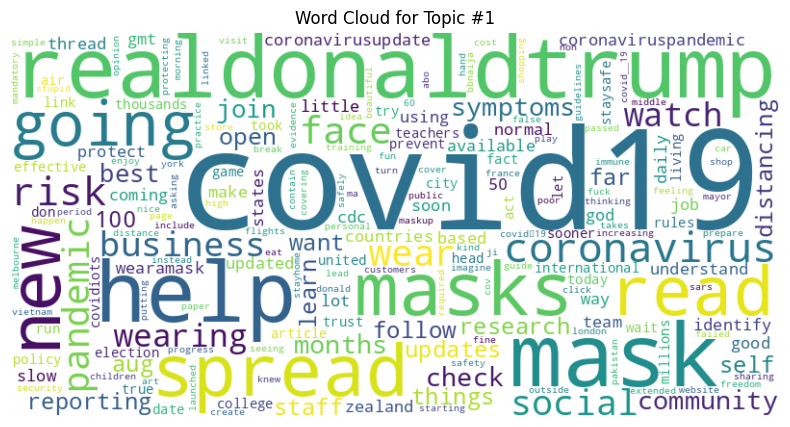

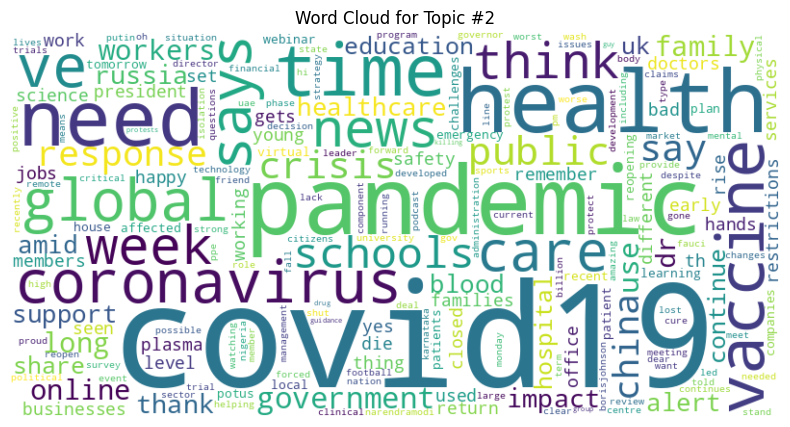

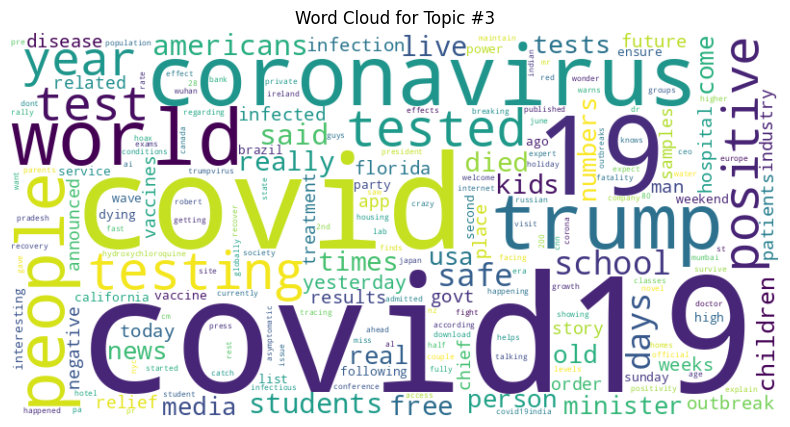

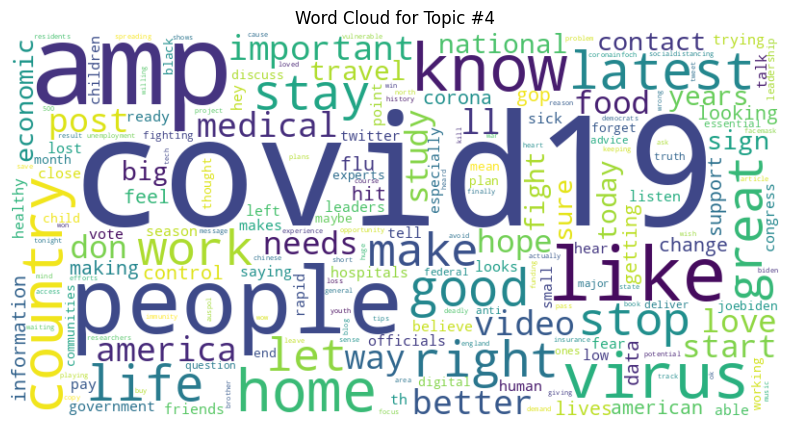

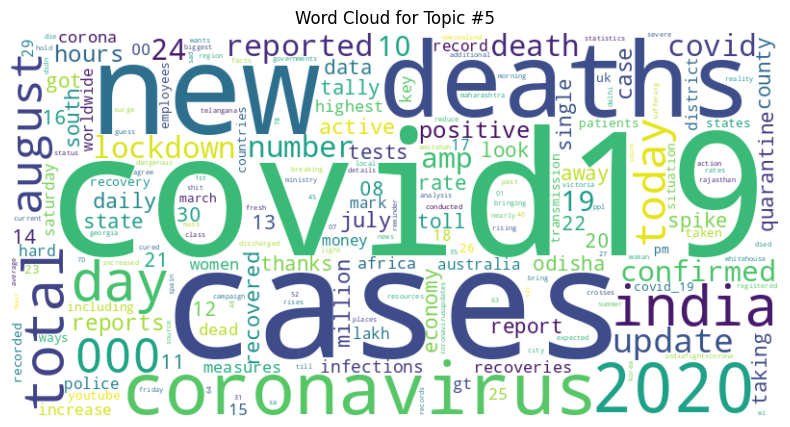

In [6]:
# Visualização de nuvens de palavras por tópico
def plot_wordclouds(lda_model, vectorizer):
    for topic_idx, topic in enumerate(lda_model.components_):
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
            dict(zip(vectorizer.get_feature_names_out(), topic))
        )
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic #{topic_idx + 1}')
        plt.show()

plot_wordclouds(lda_model, vectorizer)

## Visualização de Dados: Distribuição de Sentimentos
Nesta parte do código, é gerado e exibido um histograma para visualizar a distribuição da polaridade dos sentimentos nos textos dos tweets. Aqui está uma descrição detalhada:

### 1. Configuração da Visualização:

- `plt.figure(figsize=(8, 5))`: Define o tamanho da figura para o gráfico.
- `sns.histplot(df['sentiment'], bins=30, kde=True)`: Cria um histograma usando a biblioteca Seaborn, representando a distribuição da polaridade do sentimento. `bins=30` especifica o número de intervalos (barras) no histograma, e `kde=True` adiciona uma estimativa da densidade do kernel.
### 2. Detalhes do Gráfico:

- `plt.title('Distribuição de Sentimentos')`: Adiciona um título ao gráfico indicando a natureza da visualização.
- `plt.xlabel('Polaridade do Sentimento')`: Rotula o eixo x do gráfico.
### 3. Exibição do Gráfico:

- `plt.show()`: Exibe o gráfico.
  
Esta visualização é útil para entender a distribuição geral da polaridade dos sentimentos nos tweets. Um histograma proporciona uma visão rápida e intuitiva da tendência predominante nos sentimentos expressos nos textos. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados, realizar a análise de sentimentos e a análise de tópicos antes de executar esta seção.

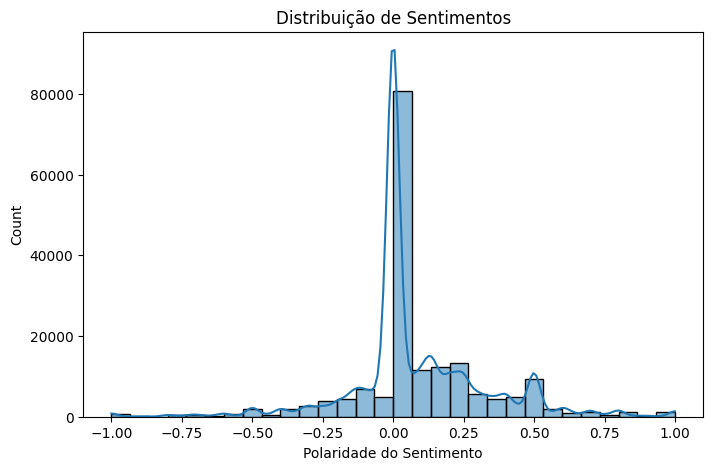

In [7]:
# Visualização de dados
plt.figure(figsize=(8, 5))
sns.histplot(df['sentiment'], bins=30, kde=True)
plt.title('Distribuição de Sentimentos')
plt.xlabel('Polaridade do Sentimento')
plt.show()

## Treinamento de um Classificador de Naive Bayes para Análise de Sentimentos
Nesta parte do código, um classificador de Naive Bayes é treinado para realizar a análise de sentimentos nos textos dos tweets. Aqui está uma descrição detalhada:

### 1. Preparação dos Dados:

- `X = df['text']`: Obtém os textos dos tweets como variável independente.
- `y = df['sentiment'].apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'neutro'))`: Obtém os rótulos de sentimentos, categorizando como 'positivo', 'negativo' ou 'neutro' com base na polaridade calculada anteriormente.
### 2. Divisão dos Dados em Conjuntos de Treino e Teste:

- `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)`: Divide o conjunto de dados em conjuntos de treino (80%) e teste (20%) para avaliação do desempenho do modelo.
### 3. Vetorização dos Textos:

- `vectorizer = CountVectorizer()`: Cria um vetorizador de contagem para converter os textos em uma matriz de contagem de tokens.
- `X_train_vec = vectorizer.fit_transform(X_train)`: Ajusta e transforma os textos de treino.
- `X_test_vec = vectorizer.transform(X_test)`: Transforma os textos de teste com base no ajuste feito nos textos de treino.
### 4. Treinamento do Classificador Naive Bayes:

- `classifier = MultinomialNB()`: Cria uma instância do classificador Naive Bayes.
- `classifier.fit(X_train_vec, y_train)`: Treina o classificador com os textos de treino e seus rótulos correspondentes.
  
Esta etapa é fundamental para a construção de um modelo de classificação capaz de predizer o sentimento dos textos com base no treinamento realizado. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados, realizar a análise de sentimentos, a análise de tópicos e a visualização de dados antes de executar esta seção.

In [8]:
# Treinamento de um classificador de Naive Bayes para análise de sentimentos
X = df['text']
y = df['sentiment'].apply(lambda x: 'positivo' if x > 0 else ('negativo' if x < 0 else 'neutro'))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)

MultinomialNB()

## Avaliação do Classificador
Nesta parte do código, o classificador treinado é avaliado usando métricas de desempenho. Aqui está uma descrição detalhada:

### 1. Predição nos Dados de Teste:

- `y_pred = classifier.predict(X_test_vec)`: Usa o classificador treinado para fazer predições nos textos de teste.
### 2. Avaliação do Desempenho do Classificador:

- `print("\nAvaliação do Classificador:")`: Imprime um cabeçalho indicando que a avaliação do classificador será exibida.
- `print("Acurácia:", accuracy_score(y_test, y_pred))`: Calcula e imprime a acurácia do classificador, que é a proporção de predições corretas.
- `print("\nMatriz de Confusão:")`: Imprime a matriz de confusão, que mostra o número de verdadeiros positivos, verdadeiros negativos, falsos positivos e falsos negativos.
- `print(confusion_matrix(y_test, y_pred))`: Imprime a matriz de confusão.
- `print("\nRelatório de Classificação:")`: Imprime um relatório de classificação que inclui precision, recall, f1-score e support para cada classe.
- `print(classification_report(y_test, y_pred))`: Imprime o relatório de classificação.
  
Esta etapa é essencial para entender como o classificador está performando em termos de precisão, recall e outras métricas relevantes. Os resultados ajudam a avaliar a eficácia do modelo na tarefa de análise de sentimentos. Certifique-se de ter executado as partes anteriores do código para carregar o conjunto de dados, realizar a análise de sentimentos, a análise de tópicos, a visualização de dados e o treinamento do classificador antes de executar esta seção.

In [9]:
# Avaliação do classificador
y_pred = classifier.predict(X_test_vec)
print("\nAvaliação do Classificador:")
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Avaliação do Classificador:
Acurácia: 0.7744402880911172

Matriz de Confusão:
[[ 1626   975  3351]
 [   84 11965  2988]
 [   94   588 14151]]

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       0.90      0.27      0.42      5952
      neutro       0.88      0.80      0.84     15037
    positivo       0.69      0.95      0.80     14833

    accuracy                           0.77     35822
   macro avg       0.83      0.67      0.69     35822
weighted avg       0.81      0.77      0.75     35822



## Resultados da Avaliação do Classificador
Os resultados da avaliação do classificador são os seguintes:

### 1. Acurácia:

- Acurácia: 0.7744 (ou 77.44%): Representa a proporção de predições corretas em relação ao total de predições.
###  2. Matriz de Confusão:

- A matriz de confusão apresenta a distribuição das predições em termos de verdadeiros positivos (TP), verdadeiros negativos (TN), falsos positivos (FP) e falsos negativos (FN).
lua
- Para interpretar:
    -  Na classe 'negativo', 1626 são verdadeiros positivos, 975 são falsos positivos e 3351 são falsos negativos.
    - Na classe 'neutro', 11965 são verdadeiros positivos, 84 são falsos positivos e 2988 são falsos negativos.
    - Na classe 'positivo', 14151 são verdadeiros positivos, 94 são falsos positivos e 588 são falsos negativos.
### 3. Relatório de Classificação:

- Precision, Recall e F1-score são métricas detalhadas para cada classe ('negativo', 'neutro', 'positivo').
- A média ponderada (weighted avg) leva em consideração o desequilíbrio nas classes.
### 4. Interpretação:

- O modelo tem uma boa acurácia geral, mas a análise do relatório de classificação revela desafios específicos em classes desbalanceadas.
- A classe 'negativo' tem uma precisão elevada, mas uma recall baixa, indicando que o modelo tem dificuldade em identificar corretamente exemplos dessa classe.
- A classe 'positivo' tem uma precisão mais baixa, mas uma recall alta, indicando que o modelo tende a identificar corretamente exemplos dessa classe, mas também classifica erroneamente alguns exemplos como positivos.
  
Estes resultados fornecem uma visão detalhada do desempenho do classificador em relação a diferentes métricas. A interpretação deve ser adaptada às necessidades específicas do projeto, considerando as características do conjunto de dados e os objetivos da análise de sentimentos.






